In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
from astropy import wcs

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
nmad = lambda x: 1.4826 * np.median(np.abs(x-np.median(x)))

ccdnamenumdict = {'S1': 25, 'S2': 26, 'S3': 27, 'S4':28,
                  'S5': 29, 'S6': 30, 'S7': 31,
                  'S8': 19, 'S9': 20, 'S10': 21, 'S11': 22, 'S12': 23,
                  'S13': 24,
                  'S14': 13, 'S15': 14, 'S16': 15, 'S17': 16, 'S18': 17,
                  'S19': 18,
                  'S20': 8, 'S21': 9, 'S22': 10, 'S23': 11, 'S24': 12,
                  'S25': 4, 'S26': 5, 'S27': 6, 'S28': 7,
                  'S29': 1, 'S30': 2, 'S31': 3,
                  'N1': 32, 'N2': 33, 'N3': 34, 'N4': 35,
                  'N5': 36, 'N6': 37, 'N7': 38,
                  'N8': 39, 'N9': 40, 'N10': 41, 'N11': 42, 'N12': 43,
                  'N13': 44,
                  'N14': 45, 'N15': 46, 'N16': 47, 'N17': 48, 'N18': 49,
                  'N19': 50,
                  'N20': 51, 'N21': 52, 'N22': 53, 'N23': 54, 'N24': 55,
                  'N25': 56, 'N26': 57, 'N27': 58, 'N28': 59,
                  'N29': 60, 'N30': 61, 'N31': 62,
                  }
ccdnamenumdict_inv = {aa: bb for bb, aa in ccdnamenumdict.items()}

fringe_dir = '/global/homes/d/djschleg/cosmo/staging/decam/DECam_CP-Fringe'
image_dir = '/global/project/projectdirs/cosmo/staging/'
# surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9-cut.fits.gz'
surveyccd_path = '/global/u2/r/rongpu/temp/survey-ccds-decam-dr9-z-band-only-trim.fits'
blob_dir = '/global/cscratch1/sd/rongpu/fringe/decam_ccd_blob_mask'

In [4]:
# Load CCD list
ccd_columns = ['image_filename', 'image_hdu', 'expnum', 'ccdname', 'filter', 'mjd_obs', 'ra', 'dec', 'skyrms', 'ccdraoff', 'ccddecoff', 'ccd_cuts']
ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
# ccd = fitsio.read(surveyccd_path)
ccd = Table(ccd)
mask = ccd['ccd_cuts']==0
mask &= ccd['filter']=='z' # include only z-band images
ccd = ccd[mask]
print(len(ccd))

ccd['ccdnum'] = [ccdnamenumdict[ccd['ccdname'][ii].strip()] for ii in range(len(ccd))]

# Load old fringe image
fringe_old_dict = {}
for ccdnum in range(1, 63):
    # skip N30 and S7
    if ccdnum==61 or ccdnum==31:
        continue
    fringe_old_path = os.path.join(fringe_dir, 'DES17B_20180103_908c062-z-{}_frg.fits'.format(str(ccdnum).zfill(2)))
    fringe_old = fits.getdata(fringe_old_path)
    # remove the edge pixels
    fringe_old = fringe_old[1:4095, 1:2047]
    fringe_old_dict[ccdnum] = fringe_old.copy()

1148265


In [31]:
ccdnum = 3
expnum = 718884

ccd_index = np.where((ccd['expnum']==expnum) & (ccd['ccdnum']==ccdnum))[0][0]
hdu_index = ccd['image_hdu'][ccd_index]

# Load CCD image
img_fn = os.path.join(image_dir, ccd['image_filename'][ccd_index]).strip()
hdulist = fits.open(img_fn)
# Some images do not have FRGSCALE in the header
frgscale = (hdulist[ccd['image_hdu'][ccd_index]].header)['FRGSCALE']
# w = wcs.WCS(hdulist[ccd['image_hdu'][ccd_index]].header)
img = hdulist[ccd['image_hdu'][ccd_index]].data

# CP mask image
ood_fn = img_fn.replace('_ooi_', '_ood_')
ood_hdulist = fits.open(ood_fn)
ood = ood_hdulist[hdu_index].data

# Back out the exisiting fringe correction
img += fringe_old_dict[ccdnum]*frgscale
img_original = img.copy()

# Load new fringe image
fringe_new_path = glob.glob('/global/project/projectdirs/desi/users/rongpu/dr9/fringe/DECam_CP-Fringe/*CCD{}.fits'.format(str(ccdnum).zfill(2)))[0]
fringe = fits.getdata(fringe_new_path)
fringe = fringe[1:4095, 1:2047]
fringe_original = fringe.copy()

# Load blob mask
str_loc = str.find(ccd['image_filename'][ccd_index].strip(), '.fits')
img_filename_base = ccd['image_filename'][ccd_index].strip()[:str_loc]
blob_path = os.path.join(blob_dir, 'blob_mask', img_filename_base+'-blobmask.npz')
blob_data = np.load(blob_path)
blob = blob_data['hdu'+str(hdu_index).zfill(2)]

# Apply masks
# blob: no source is True
img_mask = (blob==True) & (ood==0)
img[~img_mask] = np.nan

# Remove median sky
median_sky = np.median(img[np.isfinite(img)])
img = img - median_sky

# # Normalize by frgscale
# img = img/frgscale

# Trim CCD edges
img_trim_size_x = 23 + 200
img_trim_size_y = 47 + 200
img = img[img_trim_size_y:(img.shape[0]-img_trim_size_y), img_trim_size_x:(img.shape[1]-img_trim_size_x)]
fringe = fringe[img_trim_size_y:(fringe.shape[0]-img_trim_size_y), img_trim_size_x:(fringe.shape[1]-img_trim_size_x)]
print(img.shape)

# 3-sigma clipping
sky_nmad = nmad(img[np.isfinite(img)]) # sky level
print('sky nmad:', sky_nmad)
mask = (img<-3*sky_nmad) | (img>3*sky_nmad)
img[mask] = 0

(3600, 1600)
sky nmad: 23.4557382568


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in less
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in greater


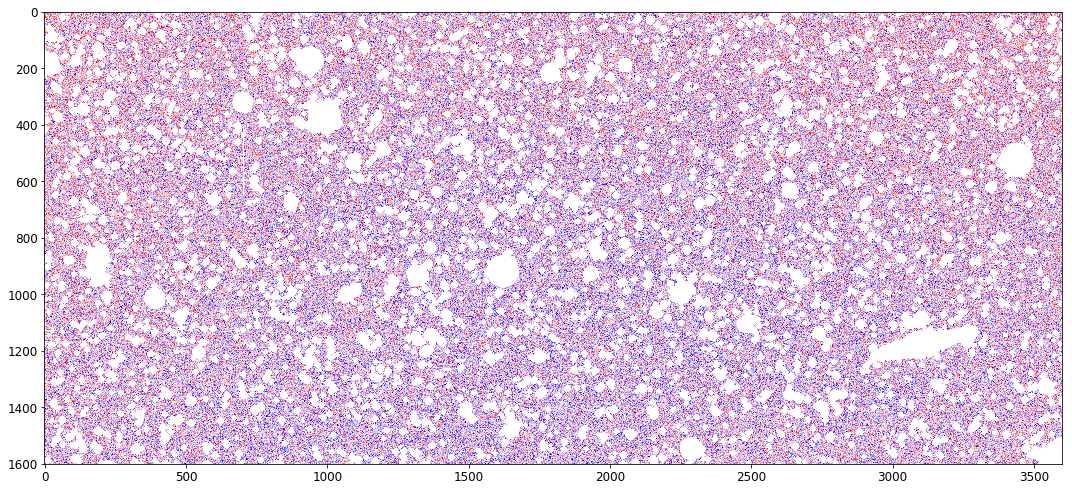

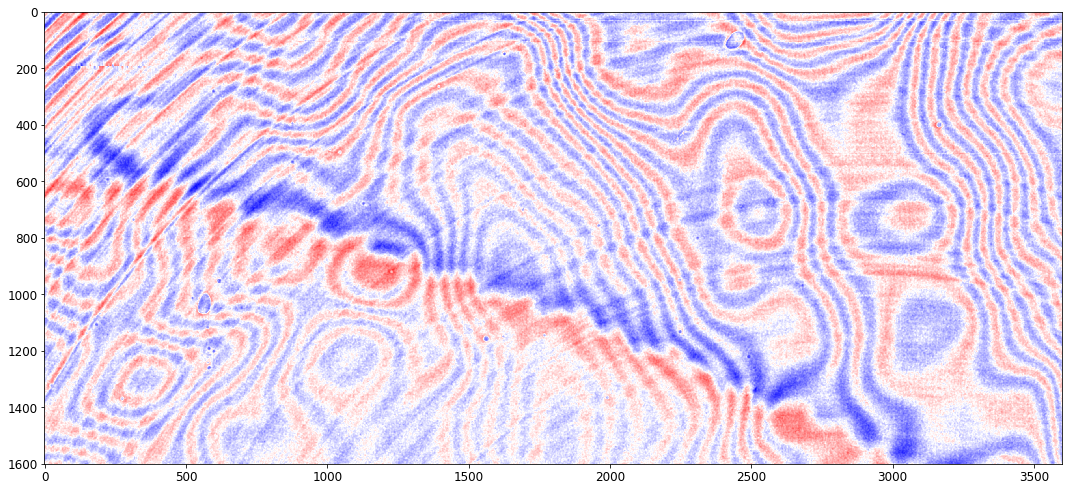

In [21]:
vrange = 5*sky_nmad
plt.figure(figsize=(15, 7))
plt.imshow((img).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.tight_layout()
plt.show()

vrange = 2e-3
plt.figure(figsize=(15, 7))
plt.imshow((fringe).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.tight_layout()
plt.show()

__Spline sky: image__

In [22]:
# spline sky
# downsize the image to speed up computation
binsize = 400
trim_size_x = 0
trim_size_y = 0
img_spline_data = np.nanmedian(np.nanmedian(img.reshape((img.shape[0]//binsize, binsize, img.shape[1]//binsize,-1)), axis=3), axis=1)
x_sky_grid = trim_size_x + binsize/2+binsize*np.arange(img_spline_data.shape[1])
y_sky_grid = trim_size_y + binsize/2+binsize*np.arange(img_spline_data.shape[0])
if np.sum(~np.isfinite(img_spline_data))!=0:
    print(np.sum(~np.isfinite(img_spline_data)), 'NAN values!')
mask = ~np.isfinite(img_spline_data)
img_spline_data[mask] = 0

from scipy.interpolate import RectBivariateSpline
spline = RectBivariateSpline(y_sky_grid, x_sky_grid, img_spline_data)
img_spline = spline(np.arange(img.shape[0]), np.arange(img.shape[1]))

# Subtract spline
img -= img_spline

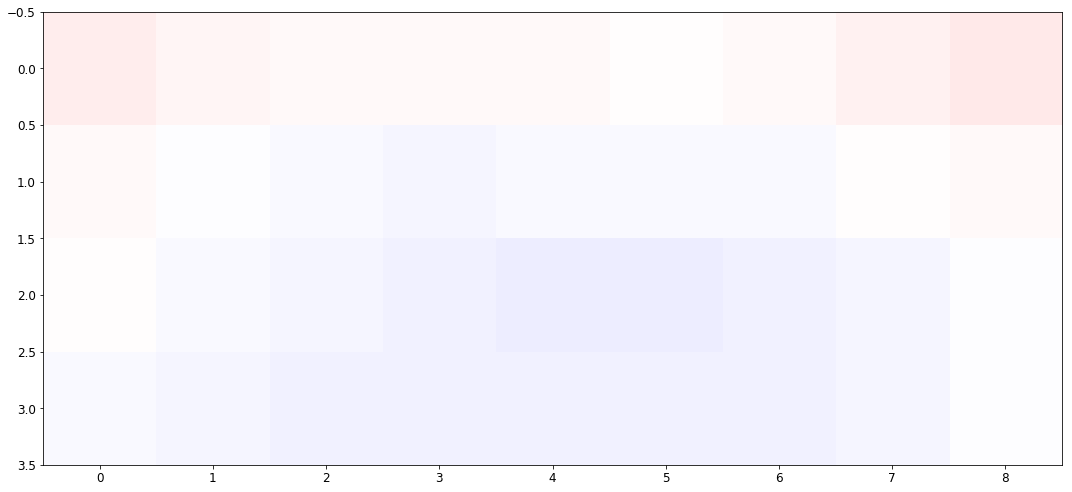

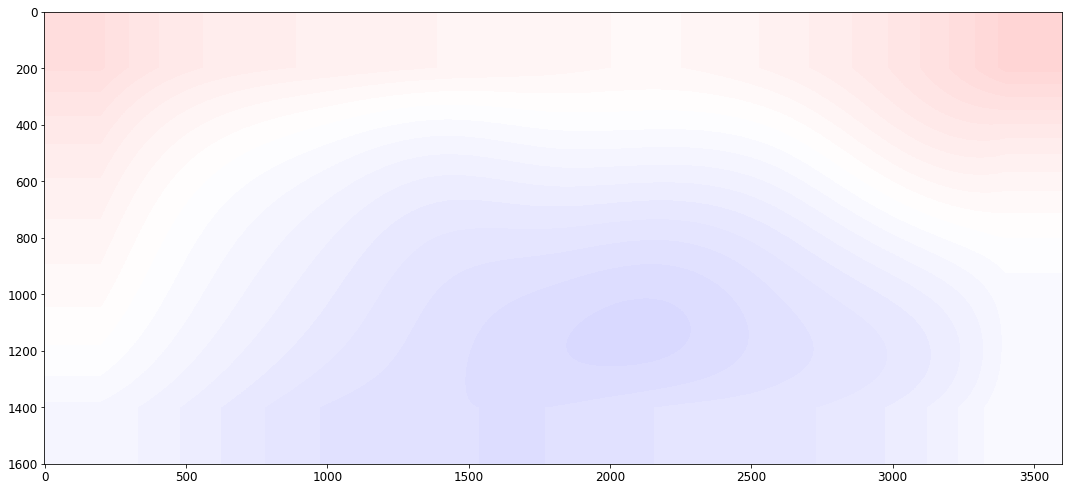

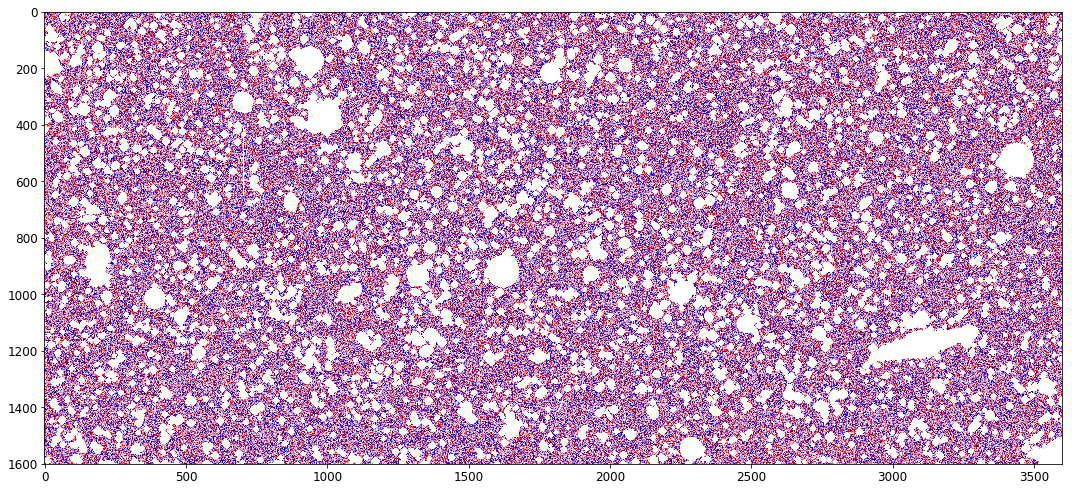

In [23]:
vrange = 5*sky_nmad
plt.figure(figsize=(15, 7))
plt.imshow((img_spline_data).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.tight_layout()
plt.show()

vrange = 2.5*sky_nmad
plt.figure(figsize=(15, 7))
plt.imshow((img_spline).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.tight_layout()
plt.show()

vrange = 2.5*sky_nmad
plt.figure(figsize=(15, 7))
plt.imshow((img).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.tight_layout()
plt.show()

__Spline sky: fringe__

In [24]:
# spline sky
# downsize the image to speed up computation
binsize = 400
trim_size_x = 0
trim_size_y = 0
fringe_spline_data = np.nanmedian(np.nanmedian(fringe.reshape((fringe.shape[0]//binsize, binsize, fringe.shape[1]//binsize,-1)), axis=3), axis=1)
x_sky_grid = trim_size_x + binsize/2+binsize*np.arange(fringe_spline_data.shape[1])
y_sky_grid = trim_size_y + binsize/2+binsize*np.arange(fringe_spline_data.shape[0])
if np.sum(~np.isfinite(fringe_spline_data))!=0:
    print(np.sum(~np.isfinite(fringe_spline_data)), 'NAN values!')

from scipy.interpolate import RectBivariateSpline
spline = RectBivariateSpline(y_sky_grid, x_sky_grid, fringe_spline_data)
fringe_spline = spline(np.arange(fringe.shape[0]), np.arange(fringe.shape[1]))

# Subtract spline
fringe -= fringe_spline

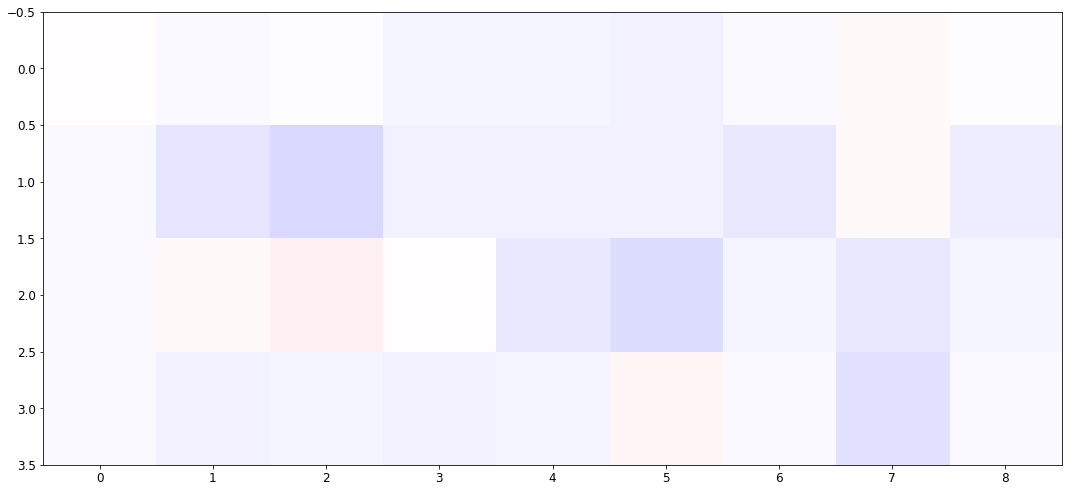

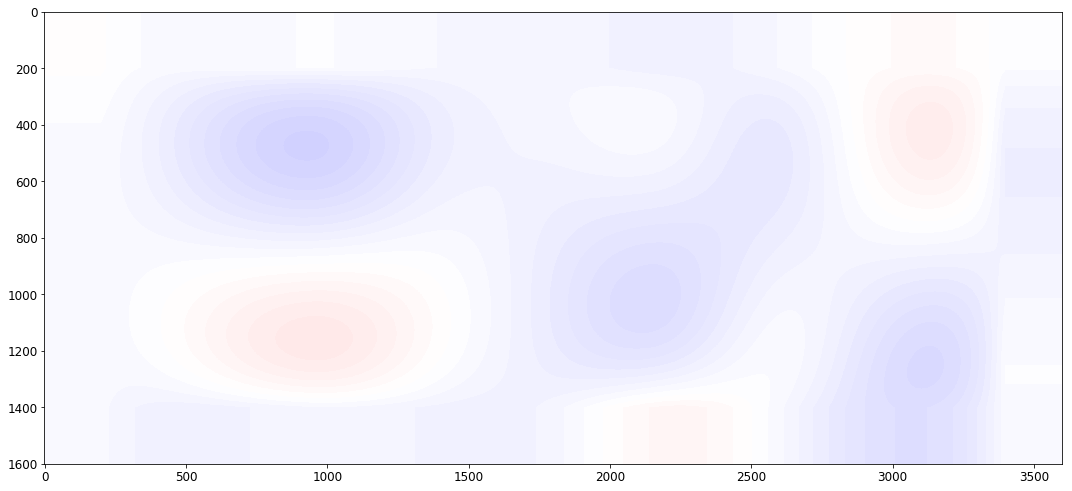

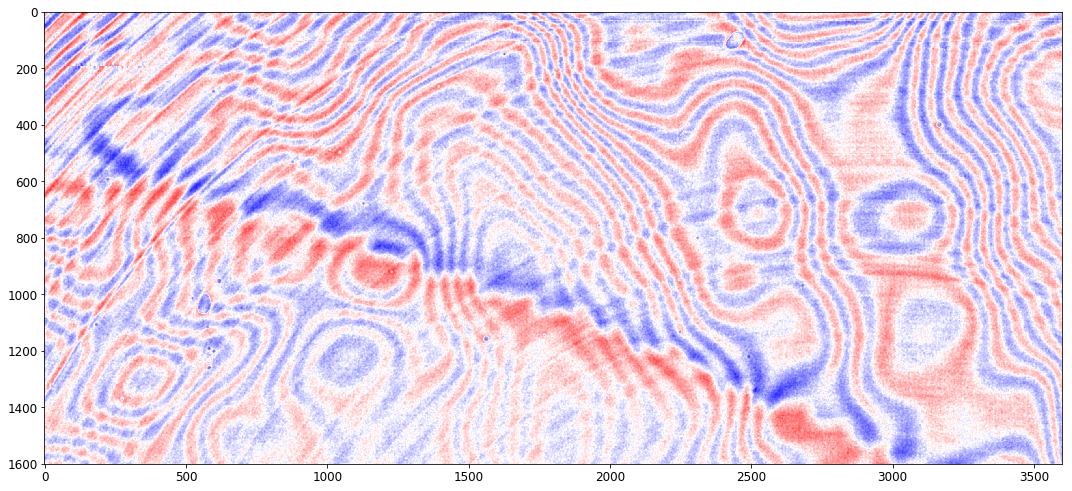

In [25]:
vrange = 2e-3
plt.figure(figsize=(15, 7))
plt.imshow((fringe_spline_data).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.tight_layout()
plt.show()

vrange = 2e-3
plt.figure(figsize=(15, 7))
plt.imshow((fringe_spline).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.tight_layout()
plt.show()

vrange = 2e-3
plt.figure(figsize=(15, 7))
plt.imshow((fringe).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.tight_layout()
plt.show()

__Linear regression__

In [26]:
img_mask = np.isfinite(img)
img_flat = img[img_mask].flatten()
fringe_flat = fringe[img_mask].flatten()

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(fringe_flat, img_flat)
print(slope, intercept, r_value, p_value, std_err)

2448.66079281 0.140345811734 0.0242400919255 0.0 47.5750061023


img 0.111011


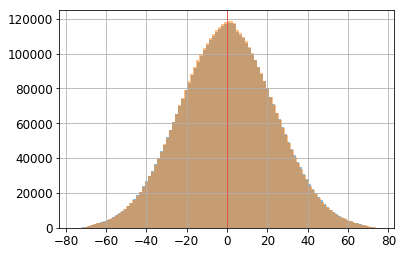

fringe 2.8466e-07


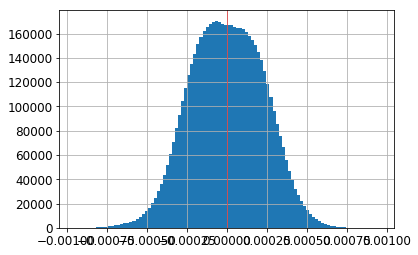

In [27]:
print('img', np.median(img[np.isfinite(img)]))
plt.hist(img_flat, 100, alpha=0.5)
plt.hist(img_flat - slope*fringe_flat, 100, alpha=0.5)
plt.axvline(0, lw=0.5, color='r')
plt.grid()
plt.show()

print('fringe', np.median(fringe[np.isfinite(fringe)]))
plt.hist(fringe[np.isfinite(fringe)], 100)
plt.axvline(0, lw=0.5, color='r')
plt.grid()
plt.show()

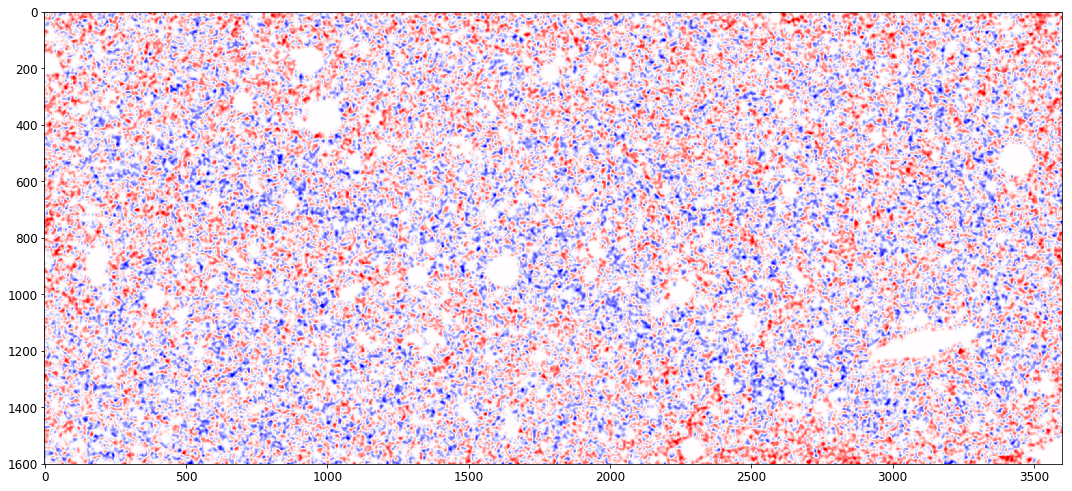

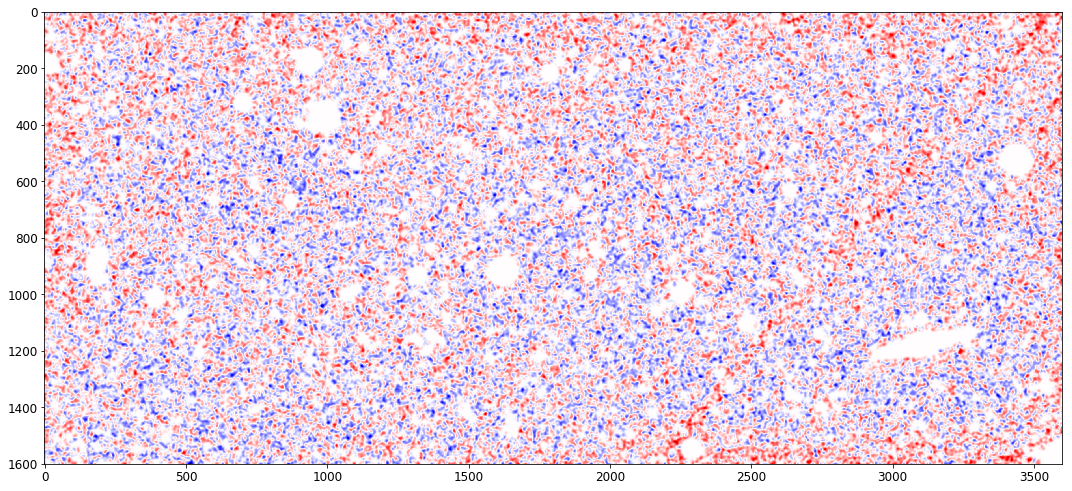

In [28]:
from scipy.ndimage.filters import gaussian_filter

img1 = img.copy()
img1[~np.isfinite(img1)] = 0
img1 = gaussian_filter(img1, 4, mode='reflect', truncate=3)

vrange = 0.5*sky_nmad
plt.figure(figsize=(15, 7))
plt.imshow((img1).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.tight_layout()
plt.show()

img1 = img - slope*fringe
img1[~np.isfinite(img1)] = 0
img1 = gaussian_filter(img1, 4, mode='reflect', truncate=3)

vrange = 0.5*sky_nmad
plt.figure(figsize=(15, 7))
plt.imshow((img1).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.tight_layout()
plt.show()

In [29]:
# img1 = (img_original - median_sky).copy()
# img1[~np.isfinite(img1)] = 0
# img1 = gaussian_filter(img1, 4, mode='reflect', truncate=3)

# vrange = 1.*sky_nmad
# plt.figure(figsize=(15, 7))
# plt.imshow((img1).T, cmap='seismic', vmin=-vrange, vmax=vrange)
# plt.tight_layout()
# plt.show()

# img1 = (img_original - median_sky - slope*fringe_original).copy()
# img1[~np.isfinite(img1)] = 0
# img1 = gaussian_filter(img1, 4, mode='reflect', truncate=3)

# vrange = 1.*sky_nmad
# plt.figure(figsize=(15, 7))
# plt.imshow((img1).T, cmap='seismic', vmin=-vrange, vmax=vrange)
# plt.tight_layout()
# plt.show()